In [1]:
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.datasets import ad_hoc_data
from itertools import chain, combinations

In [2]:
from qiskit_aer import AerSimulator
sim = AerSimulator()

# Ad Hoc Data

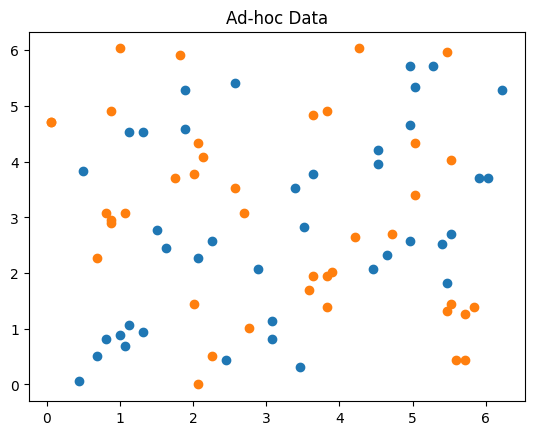

Training labels[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1]
Test labels[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1]
Size of training data(80, 2) (80,)
Size of test data(80, 2) (80,)


In [3]:
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=40,
    test_size=40,
    n=2,
    gap=0.3,
    plot_data=True,
    one_hot=False,
    include_sample_total=True,
)
train_labels = np.where(train_labels == 0, -1, 1)
test_labels = np.where(test_labels == 0, -1, 1)

print("Training labels" + str(train_labels))
print("Test labels" + str(test_labels))
print("Size of training data" + str(train_features.shape) + " " + str(train_labels.shape))
print("Size of test data" + str(test_features.shape) + " " + str(test_labels.shape))


# Feature Map

$$
Z = \left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
\qquad
Z_0Z_1 = \left(\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right)
$$

$$U_{\Phi(\vec{x})}=\exp \left(i [x_1 Z_1+x_2 Z_2+(\pi-x_1)(\pi-x_2) Z_1Z_2]\right)=\exp \left(i x_1 Z_1\right)*\exp \left(i x_2 Z_2\right)*\exp \left(i (\pi-x_1)(\pi-x_2) Z_1Z_2\right)$$

$$P(\lambda)=\left(\begin{array}{cc}
1 & 0 \\
0 & e^{i \lambda}
\end{array}\right)
\qquad 
P(-2\lambda)=\left(\begin{array}{cc}
1 & 0 \\
0 & e^{-i 2\lambda}
\end{array}\right)
=e^{-i \lambda}*\left(\begin{array}{cc}
e^{i \lambda} & 0 \\
0 & e^{-i \lambda}
\end{array}\right)
$$

$$
 \exp \left(i x_0 Z_0\right) = \left(\begin{array}{cc}
e^{i x_0} & 0 \\
0 & e^{-i x_0}
\end{array}\right)
= e^{i x_0}*P(-2x_0)
\qquad \exp \left(i x_1 Z_1\right) = \left(\begin{array}{cc}
e^{i x_1} & 0 \\
0 & e^{-i x_1}
\end{array}\right)
= e^{i x_1}*P(-2x_1)
$$

$$Z_0Z_1 = \left(\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right)
\qquad
e^{i \lambda Z_0 Z_1}=\left(\begin{array}{cccc}
e^{i \lambda} & 0 & 0 & 0 \\
0 & e^{-i \lambda} & 0 & 0 \\
0 & 0 & e^{-i \lambda} & 0 \\
0 & 0 & 0 & e^{i \lambda}
\end{array}\right)=e^{-i \lambda}*\left(\begin{array}{cc}
P(-2\lambda) & 0 \\
0 & X P(-2\lambda) X
\end{array}\right)
= e^{-i \lambda}* [C X \cdot(I \otimes P(-2\lambda)) \cdot C X]
$$

$$\text { since } X P(-2\lambda) X=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)\left(\begin{array}{cc}
e^{i \lambda} & 0 \\
0 & e^{-i \lambda}
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)=\left(\begin{array}{cc}
e^{-i \lambda} & 0 \\
0 & e^{i \lambda}
\end{array}\right)
$$

In [4]:
def powerset(iterable, size):
    s = list(range(len(iterable)))
    return chain.from_iterable(combinations(s, r) for r in range(size + 1))

In [5]:
def feature_map_custom(fm, x, reps=1):
    list_of_set = list(powerset(x, 2))

    for _ in range(reps):
        for i in range(len(x)):
            fm.h(i)
        for l in list_of_set:
            if len(l) == 0:
                continue
            if len(l) == 1:
                fm.p(-2 * x[l[0]], l[0])
            else:
                (i, j) = l
                fm.cx(i, j)
                fm.p(-2 *(np.pi-x[i])*(np.pi-x[j]), j)
                fm.cx(i, j)
        fm.barrier()
        

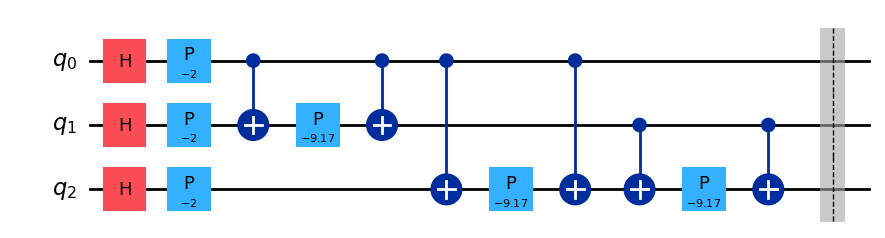

In [6]:
fm = QuantumCircuit(3)
feature_map_custom(fm, [1.0, 1.0, 1.0], 1)
fm.decompose("U_phi").draw(output='mpl')

# Ansatz

$$W(\vec{\theta})=U_{\mathrm{loc}}^{(l)}\left(\theta_l\right) U_{\mathrm{ent}} \ldots U_{\mathrm{loc}}^{(2)}\left(\theta_2\right) U_{\mathrm{ent}} U_{\mathrm{loc}}^{(1)}\left(\theta_1\right) $$

$$U_{\text {loc }}^{(t)}\left(\theta_t\right)=\otimes_{m=1}^n U\left(\theta_{m, t}\right) \qquad U\left(\theta_{m, t}\right)=e^{i \frac{1}{2} \theta_{m, t}^z Z_m} e^{i \frac{1}{2} \theta_{m, t}^y Y_m}$$

$$U_{\mathrm{ent}}=\prod_{(i, j) \in E} \mathrm{CZ}(i, j)$$

$$R Y(\theta)=\exp \left(-i \frac{\theta}{2} Y\right)=\left(\begin{array}{cc}
\cos \left(\frac{\theta}{2}\right) & -\sin \left(\frac{\theta}{2}\right) \\
\sin \left(\frac{\theta}{2}\right) & \cos \left(\frac{\theta}{2}\right)
\end{array}\right)$$

$$R Z(\lambda)=\exp \left(-i \frac{\lambda}{2} Z\right)=\left(\begin{array}{cc}
e^{-i \frac{\lambda}{2}} & 0 \\
0 & e^{i \frac{\lambda}{2}}
\end{array}\right)$$

In [7]:
def ansatz_custom(ansatz, theta, reps=1):
    for i in range(reps+1):
        if i!=0 & i!=reps:
            ansatz.cz(0, 1)
        ansatz.ry(theta[0+4*i], 0)
        ansatz.ry(theta[1+4*i], 1)
        ansatz.rz(theta[2+4*i], 0)
        ansatz.rz(theta[3+4*i], 1)

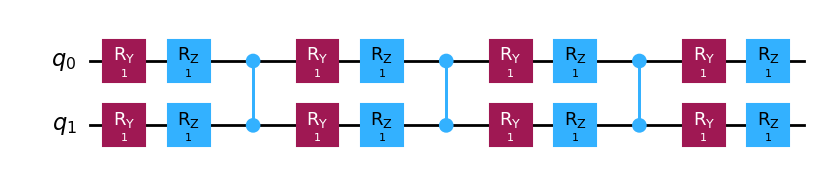

In [8]:
ansatz = QuantumCircuit(2)
ansatz_custom(ansatz, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 3)
ansatz.draw(output='mpl')

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [10]:
def single_circuit_evaluation(x, theta, shots):
    qc = QuantumCircuit(2)
    feature_map_custom(qc, x, 2)
    ansatz_custom(qc, theta, 3)
    qc.measure_all()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

In [11]:
def compute_empirical_risk(train_features, train_labels, w, shots):
    r = shots/10
    y = 0
    theta = w[:-1]
    b = w[-1]

    empirical_risk = 0
    for i in range(len(train_labels)):
        py_empirical = 0
        counts = single_circuit_evaluation(train_features[i], theta, shots)
        
        p_0 = (counts.get("00", 0)+counts.get("11", 0))/shots
        p_1 = (counts.get("01", 0)+counts.get("10", 0))/shots
        if train_labels[i] == 1:
            py_empirical = p_1
            y = 1
        else:
            py_empirical = p_0
            y = -1
        top = np.sqrt(r)*(0.5-(py_empirical-0.5*(y*b)))
        bottom = np.sqrt(2*(1-py_empirical)*py_empirical)
        empirical_risk += sigmoid(top/bottom)   
    empirical_risk /= len(train_labels)
    return empirical_risk


In [12]:
def compute_grad(train_features, train_labels, w, ck, shots):
    deltak = np.random.choice([-1, 1], len(w))

    lossplus = compute_empirical_risk(train_features, train_labels, w+ck*deltak, shots)
    lossminus = compute_empirical_risk(train_features, train_labels, w-ck*deltak, shots)

    avg_loss = (lossplus+lossminus)/2
    grad = (lossplus-lossminus)/(2*ck*(deltak))
    
    return grad, avg_loss

In [13]:
def init_c(train_features, train_labels, w, shots):
    steps = 10
    empirical_list = []
    for _ in range(steps):
        empirical_list.append(compute_empirical_risk(train_features, train_labels, w, shots))
    loss_list = np.abs(np.diff(empirical_list))
    return np.std(loss_list)*100

In [14]:
def init_a(train_features, train_labels, w, c, A, alpha, shots):
    steps = 1
    avg_magnitudes = 0
    target_magnitudes = 0.15
    for _ in range(steps):
        grad, _ = compute_grad(train_features, train_labels, w, c, shots)
        avg_magnitudes += np.abs(grad)
        
    avg_magnitudes /= steps
    return (target_magnitudes*(A**alpha) / avg_magnitudes.mean())
    

In [15]:
def do_spsa(train_features, train_labels, w, N=200, alpha = 0.602, gamma = 0.101, shots=2000):
    A = N * 0.01
    c = init_c(train_features, train_labels, w, shots)
    a = init_a(train_features, train_labels, w, c, A, alpha, shots)
    print("a: ", a)
    print("c: ", c)

    min_w = w
    min_loss = 1

    for k in range(1, N):
        ak = a / (A + k)**alpha
        ck = c / (k**gamma)
        gk, loss  = compute_grad(train_features, train_labels, w, ck, shots = shots)
        
        if loss < min_loss:
            min_loss = loss
            min_w = w

        print("\nIteration: ", k)
        print("Loss: ", loss)
        print("Grad norm: ", np.linalg.norm(gk))

        if loss < 0.11:
            break

        w = w - ak*gk

    return min_w, min_loss

In [16]:
def training_phase(train_features, train_labels, shots=2000):
    theta = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    b = 0
    
    w = theta + [b]
    theta, loss = do_spsa(train_features, train_labels, w, shots=shots)
    return theta, loss

In [17]:
def classification_phase(test_features, test_labels, theta_optimal, shots=10000):
    predictions = []
    for i in range(len(test_features)):
        counts = single_circuit_evaluation(test_features[i], theta_optimal, shots)
        p_0 = (counts.get("00", 0)+counts.get("11", 0))/shots
        p_1 = (counts.get("01", 0)+counts.get("10", 0))/shots
        if p_0 > p_1:
            predictions.append(-1)
        else:
            predictions.append(1)
    
    
    print("Test labels")
    print(test_labels)
    print("Predicted labels")
    print(predictions)
    success_rate = np.sum(np.equal(predictions, test_labels))/len(test_labels)
    print("Success rate: ", success_rate)
    return predictions, success_rate

In [18]:
theta_optimal, _ = training_phase(train_features, train_labels)

a:  1.2718423378873391
c:  0.2375065928757805

Iteration:  1
Loss:  0.4310989718636985
Grad norm:  4.368316179570472

Iteration:  2
Loss:  0.47233788667069426
Grad norm:  0.28381342759314276

Iteration:  3
Loss:  0.450938661503829
Grad norm:  1.0830088791256778

Iteration:  4
Loss:  0.4464721295818226
Grad norm:  0.09610593862149099

Iteration:  5
Loss:  0.41330312558690996
Grad norm:  1.266514240368855

Iteration:  6
Loss:  0.47487888373541765
Grad norm:  1.8874604424958037

Iteration:  7
Loss:  0.43550969490291697
Grad norm:  1.293467781634611

Iteration:  8
Loss:  0.3981096491492815
Grad norm:  0.4040035838489741

Iteration:  9
Loss:  0.3937073053105149
Grad norm:  0.7031428079887004

Iteration:  10
Loss:  0.43365642572798435
Grad norm:  0.2510422656755739

Iteration:  11
Loss:  0.3522848062321085
Grad norm:  0.561779770803272

Iteration:  12
Loss:  0.3486701222238918
Grad norm:  1.5040719476074056

Iteration:  13
Loss:  0.3496770122854513
Grad norm:  0.6839576848781733

Iteration: 

In [19]:
predict_labels, success_rate = classification_phase(train_features, train_labels, theta_optimal)

Test labels
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1]
Predicted labels
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1]
Success rate:  0.925


In [20]:
predict_labels, success_rate = classification_phase(test_features, test_labels, theta_optimal)

Test labels
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1]
Predicted labels
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1]
Success rate:  0.9375
